# 🐠 Reef - Pytorch Starter - FasterRCNN Train

## A self-contained, simple, pure pytorch 🔥 Faster R-CNN implementation with `LB=0.413`

![](https://storage.googleapis.com/kaggle-competitions/kaggle/31703/logos/header.png)

#### FasterR-CNN is one of the SOTA models for Object detection.

### In this notebook we present a simple solution using a pure pytorch Faster R-CNN with pretrained weights, and finetuning it for few epochs.

It is an adapted version of [this notebook](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train) mentioned in [this comment](https://www.kaggle.com/c/tensorflow-great-barrier-reef/discussion/290016).

## You can find the [inference notebook here](https://www.kaggle.com/julian3833/coral-reef-pytorch-fasterrcnn-infer-0-xxx).

## Details: 
- FasterRCNN from torchvision
- Use Resnet50 backbone

**Update**: Added simple train/validation split in this version, using the "subsequence" split of this notebook: [🐠 Reef - CV strategy: subsequences!](https://www.kaggle.com/julian3833/reef-cv-strategy-subsequences)

Still dropping all the images with no objects, as the model doesn't support them out-of-the-box. The other starters are removing the empty images as well, so it might be a general condition of Object Detection. I'm quite noob in the field to be honest.

# Please, _DO_ upvote if you find this useful!!


&nbsp;
&nbsp;
&nbsp;

#### Changelog

| Version | Description| Dataset| Best LB |
| --- | ----| --- | --- |
| [**V8**](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-293?scriptVersionId=80517118)  | 2 epochs - Save last epoch | [coral-reef-pytorch-starter-fasterrcnn-weights](https://www.kaggle.com/julian3833/coral-reef-pytorch-starter-fasterrcnn-weights)| `0.293`|
| [**V16**](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-293?scriptVersionId=80601095) | 4 epochs - Save all epochs | [reef-starter-torch-fasterrcnn-4e](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-4e)| `0.361` |
| [**V17**](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-369?scriptVersionId=80604402) | Add **validation**. 95-5 split. 8 epochs, keeping track of validation loss. | [reef-starter-torch-fasterrcnn-8e](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-8e)| `0.369` |
| [**V19**](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-369?scriptVersionId=80610403) | 12 epochs, lower LR | [reef-starter-torch-fasterrcnn-12e](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-12e)| `0.413` |
| [**V24**](https://www.kaggle.com/julian3833/reef-starter-torch-fasterrcnn-train-lb-0-369) | V19 with 90-10 train-validation split. Tidy up code. Add Flip. Correct problem with augmentations. | -- | `??` |




# Imports

In [1]:
# Very few imports. This is a pure torch solution!
import cv2
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

# Constants

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

NUM_EPOCHS = 12

# Load `df`

### See: [🐠 Reef - CV strategy: subsequences!](https://www.kaggle.com/julian3833/reef-cv-strategy-subsequences)

In [3]:
df = pd.read_csv("../input/reef-cv-strategy-subsequences-dataframes/train-validation-split/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,is_train
0,0,40258,0,0,0-0,[],0,False,video_0/0.jpg,1,True
1,0,40258,1,1,0-1,[],0,False,video_0/1.jpg,1,True
2,0,40258,2,2,0-2,[],0,False,video_0/2.jpg,1,True
3,0,40258,3,3,0-3,[],0,False,video_0/3.jpg,1,True
4,0,40258,4,4,0-4,[],0,False,video_0/4.jpg,1,True


In [4]:
df_train, df_val = df[df['is_train']], df[~df['is_train']]

In [5]:
# The model doesn't support images with no annotations
# It raises an error that suggest that it just doesn't support them:
# V    alueError: No ground-truth boxes available for one of the images during training
# I'm dropping those images for now
# https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/3
df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)

In [6]:
df_train.shape[0], df_val.shape[0]

(4396, 523)

# Dataset class

In [7]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        
        
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
        
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

## Augmentations

In [8]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
# Define datasets
ds_train = ReefDataset(df_train, get_train_transform())
ds_val = ReefDataset(df_val, get_valid_transform())

## Check one sample

In [10]:
# Let's get an interesting one ;)
df_train[df_train.annotations.str.len() > 12].head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,is_train
2200,1,8503,4173,345,1-4173,"[{'x': 428, 'y': 156, 'width': 36, 'height': 2...",13,True,video_1/4173.jpg,80,True
2201,1,8503,4174,346,1-4174,"[{'x': 421, 'y': 156, 'width': 36, 'height': 2...",13,True,video_1/4174.jpg,80,True
2202,1,8503,4175,347,1-4175,"[{'x': 415, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4175.jpg,80,True
2203,1,8503,4176,348,1-4176,"[{'x': 409, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4176.jpg,80,True
2204,1,8503,4177,349,1-4177,"[{'x': 403, 'y': 157, 'width': 36, 'height': 2...",13,True,video_1/4177.jpg,80,True


In [11]:
image, targets = ds_train[2200]
image

tensor([[[0.2235, 0.2314, 0.2157,  ..., 0.0039, 0.0039, 0.0039],
         [0.2706, 0.2667, 0.2353,  ..., 0.0039, 0.0039, 0.0039],
         [0.2314, 0.2314, 0.2157,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.4863, 0.4471, 0.4275,  ..., 0.0000, 0.0000, 0.0000],
         [0.4431, 0.4471, 0.4314,  ..., 0.0000, 0.0000, 0.0000],
         [0.4392, 0.4196, 0.4627,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.4941, 0.4745, 0.4510,  ..., 0.4745, 0.4745, 0.4745],
         [0.4745, 0.4627, 0.4353,  ..., 0.4745, 0.4745, 0.4745],
         [0.4667, 0.4549, 0.4588,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.8353, 0.8039, 0.7765,  ..., 0.5451, 0.5451, 0.5529],
         [0.8235, 0.8275, 0.7725,  ..., 0.5490, 0.5412, 0.5412],
         [0.8510, 0.8275, 0.8118,  ..., 0.5569, 0.5412, 0.5412]],

        [[0.5569, 0.5647, 0.5529,  ..., 0.8471, 0.8471, 0.8471],
         [0.5686, 0.5686, 0.5490,  ..., 0.8471, 0.8471, 0.8471],
         [0.5686, 0.5608, 0.5569,  ..., 0.8471, 0.8471, 0.

In [12]:
targets

{'boxes': tensor([[ 816.0000,  156.0000,  852.0000,  182.0000],
         [ 896.0000,  539.0000,  921.0000,  564.0000],
         [ 618.0000,  228.0000,  657.0000,  272.0000],
         [ 557.0000,  317.0000,  598.0000,  357.0000],
         [ 977.0000,  217.0000, 1007.0000,  242.0000],
         [ 824.0000,  172.0000,  860.0000,  208.0000],
         [ 480.0000,  376.0000,  543.0000,  443.0000],
         [ 981.0000,  293.0000, 1037.0000,  333.0000],
         [ 464.0000,  349.0000,  503.0000,  408.0000],
         [ 930.0000,  256.0000,  954.0000,  280.0000],
         [1110.0000,  409.0000, 1140.0000,  446.0000],
         [1081.0000,  450.0000, 1110.0000,  484.0000],
         [ 606.0000,  547.0000,  638.0000,  583.0000]]),
 'area': tensor([ 936.,  625., 1716., 1640.,  750., 1296., 4221., 2240., 2301.,  576.,
         1110.,  986., 1152.]),
 'image_id': tensor([2200]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

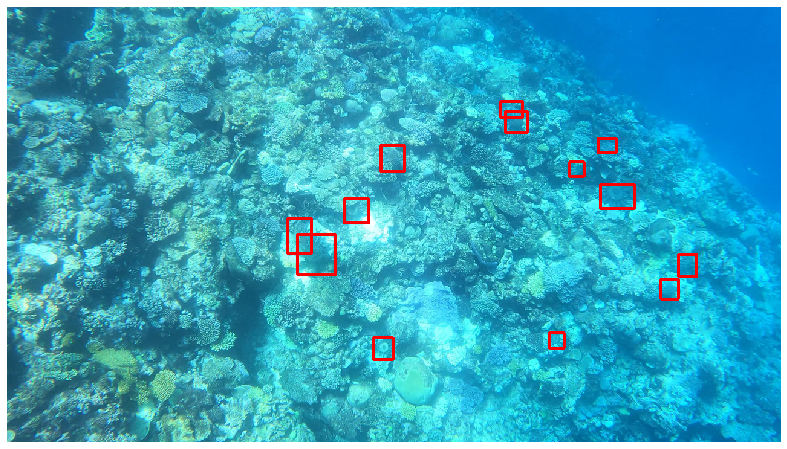

In [13]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
img = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(img);

## DataLoaders

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Create the model

In [15]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(DEVICE)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Train

In [16]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []


for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    loss_accum = 0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Validation 
    val_loss_accum = 0
        
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
    
    # Logging
    val_loss = val_loss_accum / n_batches_val
    train_loss = loss_accum / n_batches
    validation_losses.append(val_loss)
    
    # Save model
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    
    
    elapsed = time.time() - time_start
    
    print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name}  [{elapsed:.0f} secs]")   

[Epoch  1 / 12] Train loss: 0.216. Val loss: 0.257 --> fasterrcnn_resnet50_fpn-e0.bin  [772 secs]
[Epoch  2 / 12] Train loss: 0.194. Val loss: 0.320 --> fasterrcnn_resnet50_fpn-e1.bin  [769 secs]
[Epoch  3 / 12] Train loss: 0.185. Val loss: 0.261 --> fasterrcnn_resnet50_fpn-e2.bin  [770 secs]
[Epoch  4 / 12] Train loss: 0.176. Val loss: 0.239 --> fasterrcnn_resnet50_fpn-e3.bin  [769 secs]
[Epoch  5 / 12] Train loss: 0.168. Val loss: 0.225 --> fasterrcnn_resnet50_fpn-e4.bin  [767 secs]
[Epoch  6 / 12] Train loss: 0.157. Val loss: 0.221 --> fasterrcnn_resnet50_fpn-e5.bin  [767 secs]
[Epoch  7 / 12] Train loss: 0.148. Val loss: 0.220 --> fasterrcnn_resnet50_fpn-e6.bin  [767 secs]
[Epoch  8 / 12] Train loss: 0.141. Val loss: 0.218 --> fasterrcnn_resnet50_fpn-e7.bin  [773 secs]
[Epoch  9 / 12] Train loss: 0.134. Val loss: 0.222 --> fasterrcnn_resnet50_fpn-e8.bin  [773 secs]
[Epoch 10 / 12] Train loss: 0.129. Val loss: 0.226 --> fasterrcnn_resnet50_fpn-e9.bin  [778 secs]
[Epoch 11 / 12] Trai

In [17]:
validation_losses

[0.2567532156227213,
 0.3195499879392711,
 0.2607027698646892,
 0.23853198517904137,
 0.22493924290844888,
 0.22093072601340033,
 0.22010162421925503,
 0.21799993458570857,
 0.2218208314117157,
 0.22568967983578192,
 0.2391740862618793,
 0.25891267276848806]

In [18]:
np.argmin(validation_losses)

7

# Check result

In [19]:
idx = 0

images, targets = next(iter(dl_val))
images = list(img.to(DEVICE) for img in images)
targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
sample = images[idx].permute(1,2,0).cpu().numpy()

model.eval()

outputs = model(images)
outputs = [{k: v.detach().cpu().numpy() for k, v in t.items()} for t in outputs]

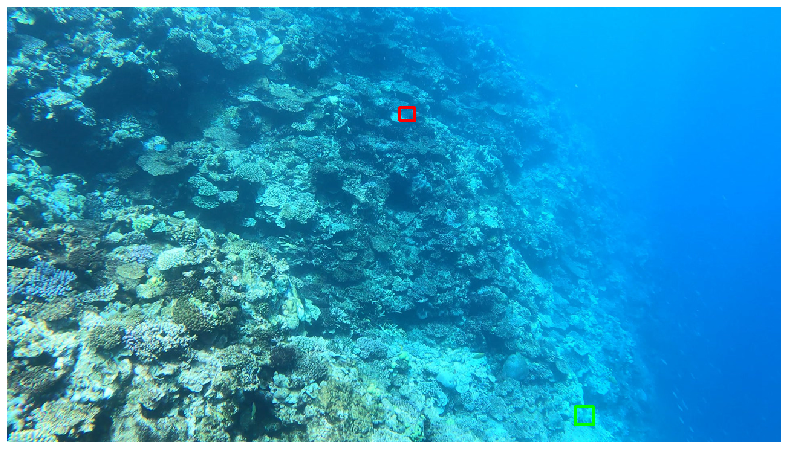

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Red for ground truth
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

    
# Green for predictions
# Print the first 5
for box in outputs[idx]['boxes'][:5]:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (0, 220, 0), 3)

ax.set_axis_off()
ax.imshow(sample);

# Please, _DO_ upvote if you found it useful!